In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import polars as pl
from my_packages.tardis_loader import TardisLoader
from datetime import datetime, timedelta
from functools import reduce

import nest_asyncio
nest_asyncio.apply()


from scipy.stats import norm, t
from statsmodels.tsa.stattools import adfuller

### Load data from Tardis

In [5]:
root_dir = './data'
api_key = 'TD.sSGNjEpohBl9i0FV.zz0-s-b6DZ9c2lt.uoNpgBPGaTITrA9.YlW26JKS0PSfoOG.2pEnnkHAnTpOloD.3wMo'

Tardis_data = TardisLoader(root_dir, api_key)

In [171]:
# Set time and exchanges
start_time = datetime.strptime('2024-09-05', '%Y-%m-%d')
end_time = datetime.strptime('2024-09-10', '%Y-%m-%d')
exchange = 'binance-futures' #'binance-futures'
symbol = 'btcusdt'

# Download the dataset
Tardis_data.download(start_time, end_time, data_type='trades', exchange=exchange, symbol=symbol)
Tardis_data.download(start_time, end_time, data_type='book_snapshot_25', exchange=exchange, symbol=symbol)
                    
# Load the data
trades_bnc = Tardis_data.read(start_time, end_time, data_type='trades', exchange=exchange, symbol=symbol)
order_book_bnc_25 = Tardis_data.read(start_time, end_time, data_type='book_snapshot_25', exchange=exchange, symbol=symbol)
order_book_bnc_10 = order_book_bnc_25.select(order_book_bnc_25.columns[:45])

# Add Latency Column
trades_bnc = trades_bnc.with_columns([
    (pl.col('local_timestamp') - pl.col('timestamp')).alias('recv_latency'),
    (pl.col('local_timestamp') - pl.col('timestamp')).shift(-1).alias('next_recv_latency')
])
trades_bnc = trades_bnc.filter(pl.col("next_recv_latency").is_not_null())

# Add Latency Column
order_book_bnc_25 = order_book_bnc_25.with_columns([
    (pl.col('local_timestamp') - pl.col('timestamp')).alias('recv_latency'),
    (pl.col('local_timestamp') - pl.col('timestamp')).shift(-1).alias('next_recv_latency')
])
order_book_bnc_25 = order_book_bnc_25.filter(pl.col("next_recv_latency").is_not_null())

# Add Latency Column
order_book_bnc_10 = order_book_bnc_10.with_columns([
    (pl.col('local_timestamp') - pl.col('timestamp')).alias('recv_latency'),
    (pl.col('local_timestamp') - pl.col('timestamp')).shift(-1).alias('next_recv_latency')
])
order_book_bnc_10 = order_book_bnc_10.filter(pl.col("next_recv_latency").is_not_null())

In [110]:
sep10_ob = order_book_bnc_25
sep10_trades = trades_bnc

In [68]:
# order_book_bnc_10.filter(order_book_bnc_10['timestamp'].diff() < 10000)

### Build Model

In [606]:
sep10_trades

human_time,exchange,symbol,timestamp,local_timestamp,id,side,price,amount,recv_latency,next_recv_latency
datetime[μs],str,str,i64,i64,i64,str,f64,f64,i64,i64
2024-09-10 00:00:03.267,"""binance-futures""","""BTCUSDT""",1725926403267000,1725926403270502,5368753744,"""buy""",57010.1,0.002,3502,4081
2024-09-10 00:00:03.272,"""binance-futures""","""BTCUSDT""",1725926403272000,1725926403276081,5368753745,"""buy""",57010.1,0.001,4081,3386
2024-09-10 00:00:03.280,"""binance-futures""","""BTCUSDT""",1725926403280000,1725926403283386,5368753746,"""sell""",57010.0,0.002,3386,3386
2024-09-10 00:00:03.280,"""binance-futures""","""BTCUSDT""",1725926403280000,1725926403283386,5368753747,"""sell""",57010.0,0.003,3386,3387
2024-09-10 00:00:03.280,"""binance-futures""","""BTCUSDT""",1725926403280000,1725926403283387,5368753748,"""sell""",57010.0,0.001,3387,3388
…,…,…,…,…,…,…,…,…,…,…
2024-09-10 23:59:59.314,"""binance-futures""","""BTCUSDT""",1726012799314000,1726012799317560,5371820214,"""buy""",57609.2,0.002,3560,3561
2024-09-10 23:59:59.314,"""binance-futures""","""BTCUSDT""",1726012799314000,1726012799317561,5371820215,"""buy""",57609.2,0.004,3561,3130
2024-09-10 23:59:59.355,"""binance-futures""","""BTCUSDT""",1726012799355000,1726012799358130,5371820216,"""sell""",57609.1,0.005,3130,3080


In [615]:
def get_single_trade(trades_df: pl.dataframe, trades_amount_threshold: int = 0.01) -> pl.dataframe:
    # Calculate the differences
    trades_df = trades_df.with_columns([
        (pl.col("timestamp").diff().fill_null(0)).alias("ts_diff"),
        (pl.col("local_timestamp").diff().fill_null(0)).alias("lts_diff")
    ])

    # Binning trades
    trades_df = trades_df.with_columns([
        ((pl.col("ts_diff") > 1000)).alias("is_new_bucket") # | (pl.col("lts_diff") > 200)
    ])

    # Calculate bucket_id
    trades_df = trades_df.with_columns([
        pl.col("is_new_bucket").cum_sum().alias("bucket_id")
    ])
    
    # Calculate bucket statistics
    trades_df_bucket = (
        trades_df.group_by('bucket_id')
        .agg([
            pl.col('timestamp').first().alias('start_time'),
            pl.col('timestamp').last().alias('end_time'),
            pl.col('price').filter(pl.col('side') == 'buy').first().alias('buy_first_price'),
            pl.col('price').filter(pl.col('side') == 'buy').last().alias('buy_last_price'),
            pl.col('amount').filter(pl.col('side') == 'buy').sum().alias('buy_volume'),
            pl.col('price').filter(pl.col('side') == 'sell').first().alias('sell_first_price'),
            pl.col('price').filter(pl.col('side') == 'sell').last().alias('sell_last_price'),
            pl.col('amount').filter(pl.col('side') == 'sell').sum().alias('sell_volume')
        ])
        .sort('start_time')
        .fill_null(0)
        )

    # Filter spike with the bucket information
    trades_df_spike = trades_df_bucket.filter(
        (pl.col("buy_volume") >= trades_amount_threshold) | (pl.col("sell_volume") >= trades_amount_threshold)
    )
    
    return trades_df_spike

In [647]:
get_single_trade(sep10_trades, trades_amount_threshold=0.1)

bucket_id,start_time,end_time,buy_first_price,buy_last_price,buy_volume,sell_first_price,sell_last_price,sell_volume
u32,i64,i64,f64,f64,f64,f64,f64,f64
3,1725926403284000,1725926403285000,0.0,0.0,0.0,57010.0,57010.0,0.668
10,1725926403317000,1725926403319000,57010.1,57013.2,4.636,57013.9,57013.9,0.003
13,1725926403331000,1725926403333000,57014.1,57019.8,0.876,0.0,0.0,0.0
16,1725926403366000,1725926403370000,57019.2,57024.5,10.506,0.0,0.0,0.0
23,1725926403408000,1725926403409000,0.0,0.0,0.0,57015.8,57015.8,0.236
…,…,…,…,…,…,…,…,…
846946,1726012796560000,1726012796562000,57607.7,57610.7,1.296,0.0,0.0,0.0
846947,1726012796651000,1726012796651000,57610.7,57610.7,0.408,0.0,0.0,0.0
846949,1726012796725000,1726012796725000,57613.6,57613.6,0.135,0.0,0.0,0.0


### Strategy Build

In [ ]:
class DynamicSpread(BacktestEngine):
    
    # Rewrite send_orders function for dynamic spread
    def quote_around_midval(self) -> None:
        '''
        Place quotes based on updated mid val
        '''
        # Get necessary data
        trades = self.trades
        orders = self.orders
        
        
        
        # Calculate the order information
        self.orders = self.orders.with_columns([
            (pl.col('mid_val') * (1 - self.min_margin/10000)).round(1).alias('bid_quote_px'),
            pl.lit(self.order_qty).alias('bid_quote_size'),
            (pl.col('mid_val') * (1 + self.min_margin/10000)).round(1).alias('ask_quote_px'),
            pl.lit(self.order_qty).alias('ask_quote_size')
        ])
        
    

### Backtest Engine

In [557]:
from typing import List, Optional
import time

class BacktestEngine:
    # Current backtest has two major difference than real one
    # 1. no skew on inventory
    # 2. no max risk
    # 3. should more focus on markout of single trade instead of overall PnL, because current system didn't look at net position nor the strategy
    # 4. To enable net position, the orders will affect each other, thus can only run sequentially. (Will sacrifice backtest speed. Is it necessary?)
    
    def __init__(self, trades_data: pl.DataFrame, order_book_data: pl.DataFrame) -> None:
        # Strategy Config
        self.min_margin = None
        self.order_qty = None
        self.update_tol = None
        
        # Following skew setting are not supported on current backtest setting
        # self.margin_rate = None
        # self.max_risk = None
        # self.max_inventory= None
        
        # Backtest Meta Setting
        self.latency_type = None
        self.default_latency = None
        self.rebates = None
        
        # Backtest Sample Filteration
        self.latency_range = None
        self.tail_sample_truncate = None

        # Intermediate Process Variables (for process checking and debuging)
        self.mid_val_ts = None
        self.orders = None
        self.orders_latency_applied = None
        self.orders_queue_added = None
        self.orders_trades_matched = None
        self.orders_markout_added = None
        self.markout_fill_rate_applied = None
        
        # Trades Logs
        # self.current_order = {'Binance_Bid': [0, 0], 'Binance_Ask': [0, 0]} # Outstanding order price and size
        # self.net_pos = 0
        self.stats = None

        # Dataframe Used for Backtest
        self.trades_bnc = trades_data
        self.orderbooks_bnc = order_book_data
        
        
    ####################
    ## Unity Function ##
    ####################

    @staticmethod
    def adjust_mid_val(mid_vals: pl.Series, tolerance: float) -> pl.Series:
        '''
        This is a closure function. Only update mid_val when the difference reached the min_update_bps
        
        PARAMS:
          tolerance: minimum price change for mid_val updating
          mid_vals: raw mid_val timeseries

        RETURN: adjusted mid_val timeseries
        '''
        adjusted_vals = []
        last_value = mid_vals[0]
        adjusted_vals.append(last_value)

        for val in mid_vals[1:]:
            if abs((val - last_value)/last_value) >= tolerance/10000:  # Check if the value increased by 'tolerance' bps
                last_value = val
            adjusted_vals.append(last_value)

        return pl.Series(adjusted_vals)
    
    
    @staticmethod
    def latest_orderbook(orderbooks: pl.DataFrame, t: int) -> pl.Series:
        '''
        Note: Do not use this function in a iter loop, which is SLOW
        
        PARAMS:
          t: timestamp, 1e15

        RETURN: The closest order book information to the timestamp
        '''
        res = (orderbooks.filter(pl.col('timestamp') <= t)
                                .sort(['timestamp', 'local_timestamp'])
                                .tail(1))
        return res
    
    
    @staticmethod
    def match_orderbooks(orderbooks: pl.DataFrame, timestamps: pl.Series) -> pl.DataFrame:
        '''
        Match order book in orderbook_collection for each timestamp in the timestamps series
        
        PARAMS:
          orderbooks: Order books collection, ordered by (timestamp, local_timestamp)
          timestamps: a Series of (unique) timestamps

        RETURN: Subset of orderbook_collection (attached after timestamps), find the nearest orderbook for each timestamp in timestamps.
        '''
        # Step 1: Sort orderbooks by timestamp and local_timestamp
        orderbooks = orderbooks.sort(by=['timestamp', 'local_timestamp'], descending=[False, True])

        # Step 2: Deduplicate orderbooks by timestamp, keeping the one with the largest local_timestamp
        dedup_orderbooks = orderbooks.unique(subset=['timestamp'], keep='first')

        # Step 3: Create a DataFrame from timestamps Series
        timestamps_df = pl.DataFrame({'matched_timestamp': timestamps})

        # Step 4: Perform an asof join to match the nearest order book timestamp
        res = timestamps_df.join_asof(
            dedup_orderbooks, 
            left_on='matched_timestamp', 
            right_on='timestamp', 
            strategy='backward'
        )

        return res
    
    
    def __match_mid_price(self, orderbooks: pl.DataFrame, timestamps: pl.Series) -> pl.Series:
        '''
        Match order book in orderbook_collection for each timestamp in the timestamps series
        
        PARAMS:
          orderbooks: Order books collection, ordered by (timestamp, local_timestamp)
          timestamps: a Series of (unique) timestamps

        RETURN: Subset of orderbook_collection (attached after timestamps), find the nearest orderbook for each timestamp in timestamps.
        '''
        matched_orderbooks = self.match_orderbooks(orderbooks, timestamps)
        
        #only return a two cols dataframe, timestamp and mid_price
        res = matched_orderbooks.select([
            ((pl.col('asks[0].price') + pl.col('bids[0].price'))/2).alias('mid_price')
        ]).to_series()

        return res
    
       
    @staticmethod
    def get_first_element_from_cat(df: pl.DataFrame, cat_var: str, var_name: str = 'arrive_timestamp') -> pl.DataFrame:
        df = (df
              .with_columns([
                  # Extract 'interval_start' from 'bin'
                  pl.col(cat_var).cast(pl.Utf8).str.extract(r"\(([^,]+),", 1).alias("interval_start")
              ])
              .filter(
                # Filter out rows where 'interval_start' is '-inf'
                pl.col("interval_start") != '-inf'
              )
              .with_columns([
                # Convert 'interval_start' to Int64 and alias as 'interval'
                pl.col('interval_start').cast(pl.Int64).alias(var_name)
              ]).drop([cat_var, 'interval_start'])
             )
        
        return df
    
    
    @staticmethod
    def get_queue_per_side(orderbooks: pl.DataFrame, our_orders: pl.DataFrame, side: str, levels: int = 10) -> pl.DataFrame:
            '''
            Get the order queue for bid and ask side.
            
            PARAMS:
                orderbooks: one side orderbook data
                our_orders: information of our orders, including order_arrived_time, quote_px, etc.
                side: 'bid' or 'ask'
            
            RETURN: Get the lowest quantity during that period for price level of our order as our queue position (strict assumption)
            '''
            # Attach corresponding order_arrived_time and quote_px to related orderbook data
            reverse_dir = {'ask': 'bid', 'bid': 'ask'}
                
            orderbooks = orderbooks.select([col for col in orderbooks.columns if reverse_dir[side] not in col])
            orderbooks = orderbooks.join(our_orders[['order_arrived_time', f"{side}_quote_px"]], on = ['order_arrived_time'], how = 'left')
            
            # Filter the vaild orderbooks which is before the first time of our quote price being hitted.
            if side == 'bid':
                ob_tmp = orderbooks.filter(
                    pl.col(f"{side}s[0].price") <= pl.col(f"{side}_quote_px")
                )
            elif side == 'ask':
                ob_tmp = orderbooks.filter(
                    pl.col(f"{side}s[0].price") >= pl.col(f"{side}_quote_px")
                )
            
            vaild_ts = ob_tmp.group_by('order_arrived_time').agg([
                pl.col("local_timestamp").first()
            ])
            
            orderbooks = orderbooks.join(vaild_ts, on = ['order_arrived_time'], how = 'left').fill_null(0)
            orderbooks = orderbooks.filter(
                pl.col("local_timestamp") < pl.col("local_timestamp_right")
            )
            
            # Only keep those rows that contain the same price as the quote_px for next step, to save memory
            bid_columns = [f"{side}s[{i}].price" for i in range(levels)]
            conditions = reduce(lambda acc, col: acc | (orderbooks[col] == orderbooks[f"{side}_quote_px"]), bid_columns, orderbooks[bid_columns[0]] == orderbooks[f"{side}_quote_px"])
            orderbooks_filtered = orderbooks.filter(conditions)
            
            # Span the price and amount col for next filter step
            price_cols = [col for col in orderbooks_filtered.columns if col.endswith('.price')]
            amount_cols = [col for col in orderbooks_filtered.columns if col.endswith('.amount')]
            
            ob_price_long = orderbooks_filtered.unpivot(on=price_cols, index=['local_timestamp', 'order_arrived_time', f"{side}_quote_px"], variable_name='price_level', value_name='price')
            ob_amount_long = orderbooks_filtered.unpivot(on=amount_cols, index=['local_timestamp', 'order_arrived_time', f"{side}_quote_px"], variable_name='amount_level', value_name='amount')
            
            ob_price_long = ob_price_long.with_columns([
                pl.col("price_level").str.replace("price", "amount").alias("amount_level")
            ])
            
            orderbooks_long = ob_price_long.join(ob_amount_long, on=['local_timestamp', 'amount_level', 'order_arrived_time', f"{side}_quote_px"], how = 'left')
            
            # Filter the orderbooks_long condition on the quote_px, finally concat it back to our_orders
            orderbooks_long = orderbooks_long.filter(
                pl.col('price') == pl.col(f'{side}_quote_px')
            )
            
            our_queue = orderbooks_long.group_by('order_arrived_time').agg([
                pl.col('amount').min().alias(f'{side}_order_queue')
            ])
                        
            return our_queue
        
    
    @staticmethod
    def get_traded_volume_per_side(trades: pl.DataFrame, our_orders: pl.DataFrame, side: str) -> pl.DataFrame:
        '''
        Given quote price and trades data, get the volume being traded at and below our quote price
        
        PARAMS:
          trades: Trades collection, ordered by (timestamp, local_timestamp)
          our_orders: information of our orders, including order_arrived_time, quote_px, etc.
          side: 'bid' or 'ask'

        RETURN: Get a series of volume traded within our quote price. (i.e. sell trades whose price lower than our bid, buy trades whose price higher than our ask)
        '''
        
        # Attach corresponding order_arrived_time and quote_px to related trades data (bid order related to sell trades)
        convert_dic = {'bid': 'sell', 'ask': 'buy'}
        
        trades = trades.filter(
            pl.col('side') == convert_dic[side]
        )
        
        trades = trades.join(our_orders[['order_arrived_time', f'{side}_quote_px']], on = ['order_arrived_time'], how = 'left')
        
        # Filter those trades that are traded at a price within our quote price
        if side == 'bid':
            valid_trades = trades.filter(
                pl.col('price') <= pl.col(f'{side}_quote_px')
            )
        elif side == 'ask':
            valid_trades = trades.filter(
                pl.col('price') >= pl.col(f'{side}_quote_px')
            )
        
        valid_traded_volume = valid_trades.group_by('order_arrived_time').agg([
            pl.col('amount').sum().alias(f'{convert_dic[side]}_volume')
        ])
        
        return valid_traded_volume
    
    
    def get_markout_per_side(self, orderbooks: pl.DataFrame, our_orders: pl.DataFrame, side: str) -> pl.DataFrame:
        '''
        Given a orderbook and our orders, using the first time that our quote price being breached as start time, calculate the markout since then.
        
        PARAMS:
            orderbooks: one side orderbook data
            our_orders: information of our orders, including order_arrived_time, quote_px, etc.
            side: 'bid' or 'ask'

        RETURN: Calculate the mark out since the first time market price reach our quote price.
        '''
        # Only keep bbo data from orderbooks
        bbos = orderbooks.select([
            pl.col('timestamp'),
            pl.col('local_timestamp'),
            pl.col('asks[0].price'),
            pl.col('bids[0].price'),
            pl.col('order_arrived_time')
        ])
        
        bbos = bbos.join(our_orders[['order_arrived_time', f"{side}_quote_px"]], on = ['order_arrived_time'], how = 'left')
        
        # Filter the vaild orderbooks which is before the first time of our quote price being hitted.
        if side == 'bid':
            ob_tmp = bbos.filter(
                pl.col(f"{side}s[0].price") <= pl.col(f"{side}_quote_px")
            )
        elif side == 'ask':
            ob_tmp = bbos.filter(
                pl.col(f"{side}s[0].price") >= pl.col(f"{side}_quote_px")
            )

        valid_ts = ob_tmp.group_by('order_arrived_time').agg([
            pl.col("timestamp").first().alias(f'{side}_markout_start_ts'),
            pl.col(f'{side}_quote_px').first()
        ])
        
        valid_ts = valid_ts.sort(f'{side}_markout_start_ts')
                
        one_ms = 1000
        one_sec = 1000000
        valid_ts = valid_ts.with_columns([
            pl.col(f'{side}_markout_start_ts'),
            (pl.col(f'{side}_markout_start_ts') + 1*one_ms).alias(f'{side}_1ms'),
            (pl.col(f'{side}_markout_start_ts') + 5*one_ms).alias(f'{side}_5ms'),
            (pl.col(f'{side}_markout_start_ts') + 10*one_ms).alias(f'{side}_10ms'),
            (pl.col(f'{side}_markout_start_ts') + 50*one_ms).alias(f'{side}_50ms'),
            (pl.col(f'{side}_markout_start_ts') + 100*one_ms).alias(f'{side}_100ms'),
            (pl.col(f'{side}_markout_start_ts') + 500*one_ms).alias(f'{side}_500ms'),
            (pl.col(f'{side}_markout_start_ts') + 1*one_sec).alias(f'{side}_1s'),
            (pl.col(f'{side}_markout_start_ts') + 5*one_sec).alias(f'{side}_5s'),
            (pl.col(f'{side}_markout_start_ts') + 10*one_sec).alias(f'{side}_10s'),
            (pl.col(f'{side}_markout_start_ts') + 50*one_sec).alias(f'{side}_50s'),
            (pl.col(f'{side}_markout_start_ts') + 100*one_sec).alias(f'{side}_100s'),
            (pl.col(f'{side}_markout_start_ts') + 500*one_sec).alias(f'{side}_500s'),
            (pl.col(f'{side}_markout_start_ts') + 1000*one_sec).alias(f'{side}_1000s')
        ])
        
        valid_price = valid_ts.select([
            pl.col('order_arrived_time'),
            pl.col(f'{side}_markout_start_ts'),
            pl.col(f'{side}_quote_px').alias(f'{side}_price_start'),
            pl.col(f'{side}_1ms').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_1ms'),
            pl.col(f'{side}_5ms').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_5ms'),
            pl.col(f'{side}_10ms').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_10ms'),
            pl.col(f'{side}_50ms').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_50ms'),
            pl.col(f'{side}_100ms').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_100ms'),
            pl.col(f'{side}_500ms').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_500ms'),
            pl.col(f'{side}_1s').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_1s'),
            pl.col(f'{side}_5s').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_5s'),
            pl.col(f'{side}_10s').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_10s'),
            pl.col(f'{side}_50s').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_50s'),
            pl.col(f'{side}_100s').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_100s'),
            pl.col(f'{side}_500s').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_500s'),
            pl.col(f'{side}_1000s').map_batches(lambda markout_ts: self.__match_mid_price(bbos, markout_ts)).alias(f'{side}_price_1000s')
        ])
        
        
        if side == 'bid':
            valid_markout = valid_price.select([
                pl.col('order_arrived_time'),
                pl.col(f'{side}_markout_start_ts'),
                pl.col(f'{side}_price_start'),
                (self.rebates + 10000*(pl.col(f'{side}_price_1ms')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_1ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_5ms')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_5ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_10ms')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_10ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_50ms')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_50ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_100ms')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_100ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_500ms')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_500ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_1s')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_1s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_5s')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_5s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_10s')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_10s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_50s')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_50s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_100s')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_100s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_500s')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_500s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_1000s')-pl.col(f'{side}_price_start'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_1000s')
            ])
        elif side == 'ask':
            valid_markout = valid_price.select([
                pl.col('order_arrived_time'),
                pl.col(f'{side}_markout_start_ts'),
                pl.col(f'{side}_price_start'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_1ms'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_1ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_5ms'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_5ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_10ms'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_10ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_50ms'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_50ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_100ms'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_100ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_500ms'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_500ms'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_1s'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_1s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_5s'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_5s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_10s'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_10s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_50s'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_50s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_100s'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_100s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_500s'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_500s'),
                (self.rebates + 10000*(pl.col(f'{side}_price_start')-pl.col(f'{side}_price_1000s'))/pl.col(f'{side}_price_start')).alias(f'{side}_markout_1000s')
            ])
            
        return valid_markout
    
    
    ###################
    ## Main Function ##
    ###################

    def calculate_midval(self, strat_ma_window: int = 1) -> None: # Calculate the mid_val for market making pricing
        '''
        This can be overided, the default one is simply using BBO mid_price as fair price
        
        PARAMS:
            strat_ma_window: moving average window, 1 means original data
        '''
        # Calculate the mid price (from BBO) as the fair price
        mid_price_bnc = (self.orderbooks_bnc['asks[0].price'] + self.orderbooks_bnc['bids[0].price'])/2

        # Initialize mid_val using moving average of binance wmid_price
        if self.mid_val_ts is None:
            mid_price_ma = mid_price_bnc.rolling_mean(window_size=strat_ma_window).round(2).fill_null(0)
            self.mid_val_ts = pl.DataFrame({
                'timestamp': self.orderbooks_bnc['timestamp'],
                'mid_val': mid_price_ma
            })
        else:
            raise('The mid_val has been initialized already, need to restart the backtest')
    
    
    def post_midval(self) -> None:
        '''
        Pull out some necessary step before sedning mid-val, in case of dupulication in stratey overwriting
        '''
        # Tolerance for mid_val updating
        tolerance = self.update_tol
        self.mid_val_ts = self.mid_val_ts.with_columns([
            pl.col('mid_val').map_batches(lambda mid_val_ts: self.adjust_mid_val(mid_val_ts, tolerance)).alias('adjusted_mid_val')
        ])
        
        # Only keep the mid_val when it was updated
        orders = self.mid_val_ts.filter(
            pl.col('adjusted_mid_val') != pl.col('adjusted_mid_val').shift(1).fill_null(0)
        )
        
        self.orders = orders.select([
            pl.col('timestamp'),
            pl.col('adjusted_mid_val').alias('mid_val'),
        ])
        
    
    def quote_around_midval(self) -> None:
        '''
        Place quotes based on updated mid val
        '''
        # Calculate the order information        
        self.orders = self.orders.with_columns([
            (pl.col('mid_val') * (1 - self.min_margin/10000)).round(1).alias('bid_quote_px'),
            pl.lit(self.order_qty).alias('bid_quote_size'),
            (pl.col('mid_val') * (1 + self.min_margin/10000)).round(1).alias('ask_quote_px'),
            pl.lit(self.order_qty).alias('ask_quote_size')
        ])
    
    
    def post_quotes(self) -> None:
        '''
        Pull out some necessary step before sending orders, in case of dupulication in stratey overwriting
        '''
        # Attach corresponding market price
        nearest_orderbooks = self.match_orderbooks(orderbooks = self.orderbooks_bnc, timestamps = self.orders['timestamp'])
        
        best_bbo = nearest_orderbooks.select([
            pl.col('matched_timestamp').alias('timestamp'),
            pl.col('bids[0].price').alias('bid_mkt_px'),
            pl.col('bids[0].amount').alias('bid_mkt_amount'),
            pl.col('asks[0].price').alias('ask_mkt_px'),
            pl.col('asks[0].amount').alias('ask_mkt_amount'),
            pl.col('recv_latency'),
            pl.col('next_recv_latency')
        ])
                
        self.orders = self.orders.join(best_bbo, on='timestamp', how='left')
        
        
        
    def apply_latency(self) -> None:
        '''
        Apply latency to the orders we sent, which will determine the time when the order arrive exchanges.
        '''
        # filter those order whose latency is within latency range, e.g. (0, 50)
        self.orders_latency_applied = self.orders.filter(pl.col('recv_latency') >= self.latency_range[0] * 1000)
        self.orders_latency_applied = self.orders_latency_applied.filter(pl.col('recv_latency') <= self.latency_range[1] * 1000)
        
        # fixed -> fixed latency, dynamic -> nearest multiplier of 5ms (5ms, 10ms, 15ms, etc) to smooth latency
        if self.latency_type == 'fixed':
            self.orders_latency_applied = self.orders_latency_applied.with_columns([
                pl.lit(self.default_latency * 1000).alias('send_latency')
            ])
        # Dynamic 有一个假设, 就是我们用的下一个order的latency而不是前一个order, 但是这个不能作为筛选只能用作环境回测, 因为这是未来信息
        # 不稳定, 因为总有一些后来发出的order先到达exchange的情况
        elif self.latency_type == 'dynamic':
            self.orders_latency_applied = self.orders_latency_applied.with_columns([
                pl.when((pl.col("next_recv_latency") + 2500) // 5000 * 5000 < 5000)
                  .then(5000)
                  .otherwise((pl.col("next_recv_latency") + 2500) // 5000 * 5000)
                  .alias("send_latency")
            ])
            
        self.orders_latency_applied = self.orders_latency_applied.with_columns([
            (pl.col('timestamp') + pl.col('recv_latency') + pl.col('send_latency')).alias('order_arrived_time')
        ])
        
        # Get corresponding market price
        nearest_orderbooks = self.match_orderbooks(orderbooks = self.orderbooks_bnc, timestamps = self.orders_latency_applied['order_arrived_time'])
        
        best_bbo = nearest_orderbooks.select([
            pl.col('matched_timestamp').alias('order_arrived_time'),
            pl.col('bids[0].price').alias('bid_mkt_px_arrive'),
            pl.col('bids[0].amount').alias('bid_mkt_amount_arrive'),
            pl.col('asks[0].price').alias('ask_mkt_px_arrive'),
            pl.col('asks[0].amount').alias('ask_mkt_amount_arrive'),
        ])
        
        orders_latency_applied = self.orders_latency_applied.join(best_bbo, on='order_arrived_time', how='left')
        orders_latency_applied = orders_latency_applied.with_columns([
            (pl.col('bid_quote_px') < pl.col('ask_mkt_px_arrive')).alias('bid_quote_valid'),
            (pl.col('ask_quote_px') > pl.col('bid_mkt_px_arrive')).alias('ask_quote_valid')
        ])

        duplicates = orders_latency_applied['order_arrived_time'].is_duplicated()
        if duplicates.any():
            ts = orders_latency_applied.filter(duplicates)['timestamp'][0]
            print(f'There is duplicated order arrived time, check order book at {ts}')
            
        self.orders_latency_applied = orders_latency_applied
        
    
    def apply_queue(self, search_levels: int = 10) -> pl.DataFrame:
        '''
        Get the order queue for each order we sent to the exchange. (best queue until it was at top of the book)
        '''
    
        # Drop arrived time duplication
        our_orders = self.orders_latency_applied
        our_orders = our_orders.unique(subset=['order_arrived_time'], keep='first')
        
        orderbooks = self.orderbooks_bnc
        
        orderbooks = orderbooks.with_columns([
            pl.col('timestamp').cut(our_orders['order_arrived_time']).alias('bins')
        ])

        orderbooks = self.get_first_element_from_cat(df = orderbooks, cat_var = 'bins', var_name = 'order_arrived_time')
        
        our_bid_queue = self.get_queue_per_side(orderbooks = orderbooks, our_orders = our_orders, side='bid', levels=search_levels)
        our_ask_queue = self.get_queue_per_side(orderbooks = orderbooks, our_orders = our_orders, side='ask', levels=search_levels)
        
        our_orders_queue_added = our_orders.join(our_bid_queue, on='order_arrived_time', how='left').fill_null(0)
        our_orders_queue_added = our_orders_queue_added.join(our_ask_queue, on='order_arrived_time', how='left').fill_null(0)

        self.orders_queue_added = our_orders_queue_added
    
    
    def get_filled_position(self):
        '''
        Get filled amount of the orders we sent
        '''
        our_orders = self.orders_queue_added
        trades = self.trades_bnc
        
        trades = trades.with_columns([
            pl.col('timestamp').cut(our_orders['order_arrived_time']).alias('bins')
        ])
                
        trades = self.get_first_element_from_cat(df = trades, cat_var = 'bins', var_name = 'order_arrived_time')
        
        buy_volume = self.get_traded_volume_per_side(trades, our_orders, side='ask')
        sell_volume = self.get_traded_volume_per_side(trades, our_orders, side='bid')
        
        our_orders_trades_matched = our_orders.join(buy_volume, on='order_arrived_time', how='left').fill_null(0)
        our_orders_trades_matched = our_orders_trades_matched.join(sell_volume, on='order_arrived_time', how='left').fill_null(0)
        
        our_orders_trades_matched = our_orders_trades_matched.with_columns([
            pl.min_horizontal(
                pl.col('sell_volume') - pl.col('bid_order_queue'),
                pl.col('bid_quote_size')
            ).alias('bid_filled_size'),

            pl.min_horizontal(
                pl.col('buy_volume') - pl.col('ask_order_queue'),
                pl.col('ask_quote_size')
            ).alias('ask_filled_size')
        ])
        
        # If filled size < 0, we set it to be 0.
        our_orders_trades_matched = our_orders_trades_matched.with_columns(
            pl.when(pl.col("bid_filled_size") < 0)
              .then(pl.lit(0))  # Set to 0 if the condition is True
              .otherwise(pl.col("bid_filled_size"))  # Keep original value otherwise
              .alias("bid_filled_size"),  # Replace the column
            
            pl.when(pl.col("ask_filled_size") < 0)
              .then(pl.lit(0))  # Set to 0 if the condition is True
              .otherwise(pl.col("ask_filled_size"))  # Keep original value otherwise
              .alias("ask_filled_size")  # Replace the column
        )
        
        
        self.orders_trades_matched = our_orders_trades_matched        
        
    
    ##################################
    ## Post-trade Analysis Function ##
    ##################################

    def calculate_markout(self):
        '''
        Calculate the markout
        '''
        our_orders = self.orders_trades_matched
        orderbooks = self.orderbooks_bnc
        
        # Turncate our orders data
        sample_truncate = self.tail_sample_truncate * 1000000
        time_anchor = orderbooks['timestamp'][-1] - sample_truncate
        our_orders = our_orders.filter(
            our_orders['timestamp'] <= time_anchor
        )
        
        orderbooks = orderbooks.with_columns([
            pl.col('timestamp').cut(our_orders['order_arrived_time']).alias('bins')
        ])

        orderbooks = self.get_first_element_from_cat(df = orderbooks, cat_var = 'bins', var_name = 'order_arrived_time')
        
        # return self.get_markout_per_side(orderbooks, our_orders, side='bid')
        bid_side_markout = self.get_markout_per_side(orderbooks, our_orders, side='bid')
        ask_side_markout = self.get_markout_per_side(orderbooks, our_orders, side='ask')
        
        our_orders_markout_added = our_orders.join(bid_side_markout, on = ['order_arrived_time'], how = 'left')#.fill_null(0)
        our_orders_markout_added = our_orders_markout_added.join(ask_side_markout, on = ['order_arrived_time'], how = 'left')#.fill_null(0)

        self.orders_markout_added = our_orders_markout_added
    
    
    def merge_markout(self):
        '''
        Get the pure markout data for plot and metric calculation
        '''
        # Extract the relevant bid/ask markout columns
        df = self.orders_markout_added
        
        bid_markout_columns = [col for col in df.columns if col.startswith('bid_markout')]
        bid_markout_columns.remove('bid_markout_start_ts')
        ask_markout_columns = [col for col in df.columns if col.startswith('ask_markout')]
        ask_markout_columns.remove('ask_markout_start_ts')

        # Define a function to multiply sizes with corresponding markouts for bid/ask
        def multiply_markouts(df: pl.DataFrame, size_column: str, markout_columns: [str]) -> pl.DataFrame:
            for col in markout_columns:
                new_col_name = f"{col}_fill_rate_applied"
                #quote_size_col = size_column[0:3] + '_quote_size'
                total_filled_amount = df[size_column].sum()
                sample_num = df.shape[0]
                df = df.with_columns(
                    (pl.col(size_column) * pl.col(col) / total_filled_amount * sample_num).alias(new_col_name)
                )
            return df
        
        df = multiply_markouts(df, 'bid_filled_size', bid_markout_columns)
        df = multiply_markouts(df, 'ask_filled_size', ask_markout_columns)
                        
        bid_markout_columns_filled = [col + '_fill_rate_applied' for col in bid_markout_columns]
        ask_markout_columns_filled = [col + '_fill_rate_applied' for col in ask_markout_columns]
        
        markout = df.select(bid_markout_columns_filled + ask_markout_columns_filled)
                        
        # Concat the bid and ask columns together
        bid_columns = [col for col in markout.columns if 'bid_markout' in col]
        bid_df = markout.select(bid_columns)
        bid_column_names = {col: col.replace('bid_', '') for col in bid_df.columns}
        bid_df = bid_df.rename(bid_column_names)

        ask_columns = [col for col in markout.columns if 'ask_markout' in col]
        ask_df = markout.select(ask_columns)
        ask_column_names = {col: col.replace('ask_', '') for col in ask_df.columns}
        ask_df = ask_df.rename(ask_column_names)

        df = pl.concat([bid_df, ask_df])
        
        # Filter those null row
        df = df.filter(~pl.col('markout_1ms_fill_rate_applied').is_null())

        self.markout_fill_rate_applied = df
        

    def plot(self):
        # Load the data
        data = self.markout_fill_rate_applied
        data = data.to_pandas()

        # Prepare the x-axis as the time intervals (log scale)
        x_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
        x_labels = ['1ms', '5ms', '10ms', '50ms', '100ms', '500ms', '1s', '5s', '10s', '50s', '100s', '500s', '1000s']
        markout_columns = [col for col in data.columns if 'markout' in col]

        # Calculate mean, 10% quantile, and 90% quantile for each time interval
        mean_values = data[markout_columns].mean()
        quantile_10 = data[markout_columns].quantile(0.10)
        quantile_90 = data[markout_columns].quantile(0.90)

        # Create subplots with two plots side by side
        fig = make_subplots(rows=1, cols=2, subplot_titles=("Markout Mean", "Mean with Quantiles"))

        # --- Left Plot: Mean Only ---
        # Plot the mean values on the left plot (subplot 1, 1), and show the legend for the mean here only
        fig.add_trace(go.Scatter(x=x_values, y=mean_values, mode='lines+markers',
                                 name='Mean', line=dict(color='blue', width=2), marker=dict(symbol='circle', size=8)),
                      row=1, col=1)

        # --- Right Plot: Mean with Quantiles ---
        # Plot the mean values with a line connecting them on the right plot, but hide the mean from the legend here
        fig.add_trace(go.Scatter(x=x_values, y=mean_values, mode='lines+markers',
                                 name='Mean', line=dict(color='blue', width=2), marker=dict(symbol='circle', size=8),
                                 showlegend=False),  # Hide mean in this legend
                      row=1, col=2)

        # Plot vertical lines connecting 10%, mean, and 90% for each x value (no legend entry)
        for i, x in enumerate(x_values):
            fig.add_trace(go.Scatter(x=[x, x, x], y=[quantile_10.iloc[i], mean_values.iloc[i], quantile_90.iloc[i]],
                                     mode='lines',
                                     line=dict(color='gray', width=2),
                                     showlegend=False),
                          row=1, col=2)

        # Plot the 10th percentile with dots
        fig.add_trace(go.Scatter(x=x_values, y=quantile_10, mode='markers', name='10th Percentile',
                                 marker=dict(color='green', symbol='circle', size=8)),
                      row=1, col=2)

        # Plot the 90th percentile with dots
        fig.add_trace(go.Scatter(x=x_values, y=quantile_90, mode='markers', name='90th Percentile',
                                 marker=dict(color='red', symbol='circle', size=8)),
                      row=1, col=2)

        # Customize the layout with explicit x-axis labels and separated legends
        fig.update_layout(
            title="Markout Data: Mean and Quantiles",
            xaxis=dict(title="Time Interval", type='log', tickvals=x_values, ticktext=x_labels),  # Custom x-axis labels for left plot
            xaxis2=dict(title="Time Interval", type='log', tickvals=x_values, ticktext=x_labels),  # Custom x-axis labels for right plot
            yaxis=dict(title="Mean Values"),  # Left plot y-axis for mean values
            yaxis2=dict(title="Values"),  # Right plot y-axis for mean and quantiles
            hovermode="x unified",
            template="plotly_white",
            width=2000,  # Set the total width of the plot
            height=700   # Set the total height of the plot
        )

        # Show the interactive plot
        fig.show()
    
    
    def post_trades_analysis(self):
        data = self.orders_markout_added
        
        bid_filled_volume = data['bid_filled_size'].sum()
        ask_filled_volume = data['ask_filled_size'].sum()
        
        bid_fill_rate = bid_filled_volume / (data['bid_quote_size'] * data['bid_quote_valid']).sum()
        ask_fill_rate = ask_filled_volume / (data['ask_quote_size'] * data['ask_quote_valid']).sum()
        
        stats = {
            "bid_filled_volume": bid_filled_volume,
            "ask_filled_volume": ask_filled_volume,
            "bid_fill_rate": bid_fill_rate,
            "ask_fill_rate": ask_fill_rate
        }
        
        self.stats = pl.DataFrame(stats)
        


    ###################
    ## Run Backtest! ##
    ###################
    
    def update_strat_config(self, min_margin: float, order_qty: float, update_tol: float) -> None:
        self.min_margin = min_margin
        self.order_qty = order_qty
        self.update_tol = update_tol
    
    def update_env_variables(self, default_latency: int, latency_type: str, rebates: float) -> None:
        self.default_latency = default_latency
        self.latency_type = latency_type
        self.rebates = rebates
        
    def update_sample_filter(self, latency_range: (int, int), tail_sample_truncate: int) -> None:
        '''
        PARAMS:
            latency_range: what is the latency range should be considered in our range
            tail_sample_cut: how many seconds of sample at end of the day should be filter out for mark out calculation
        '''
        self.latency_range = latency_range
        self.tail_sample_truncate = tail_sample_truncate
        
    def run_backtest(self):
        # Strategy initializing
        start_time = time.time()
        self.calculate_midval()
        print(f"Time for calculate_midval: {time.time() - start_time:.6f} seconds")

        start_time = time.time()
        self.post_midval()
        print(f"Time for post_midval: {time.time() - start_time:.6f} seconds")

        start_time = time.time()
        self.quote_around_midval()
        print(f"Time for quote_around_midval: {time.time() - start_time:.6f} seconds")

        start_time = time.time()
        self.post_quotes()
        print(f"Time for post_quotes: {time.time() - start_time:.6f} seconds")

        # Simulate trades
        start_time = time.time()
        self.apply_latency()
        print(f"Time for apply_latency: {time.time() - start_time:.6f} seconds")

        start_time = time.time()
        self.apply_queue(search_levels=25)
        print(f"Time for apply_queue: {time.time() - start_time:.6f} seconds")

        start_time = time.time()
        self.get_filled_position()
        print(f"Time for get_filled_position: {time.time() - start_time:.6f} seconds")

        # Post trades analysis
        start_time = time.time()
        self.calculate_markout()
        print(f"Time for calculate_markout: {time.time() - start_time:.6f} seconds")

        start_time = time.time()
        self.merge_markout()
        print(f"Time for merge_markout: {time.time() - start_time:.6f} seconds")

        start_time = time.time()
        self.post_trades_analysis()
        print(f"Time for post_trades_analysis: {time.time() - start_time:.6f} seconds")

Time for calculate_midval: 0.164131 seconds
Time for post_midval: 0.261795 seconds
Time for quote_around_midval: 0.001793 seconds
Time for post_quotes: 4.604585 seconds
Time for apply_latency: 3.829267 seconds
Time for apply_queue: 9.693796 seconds
Time for get_filled_position: 2.525858 seconds
Time for calculate_markout: 5.274944 seconds
Time for merge_markout: 0.008982 seconds
Time for post_trades_analysis: 0.000464 seconds


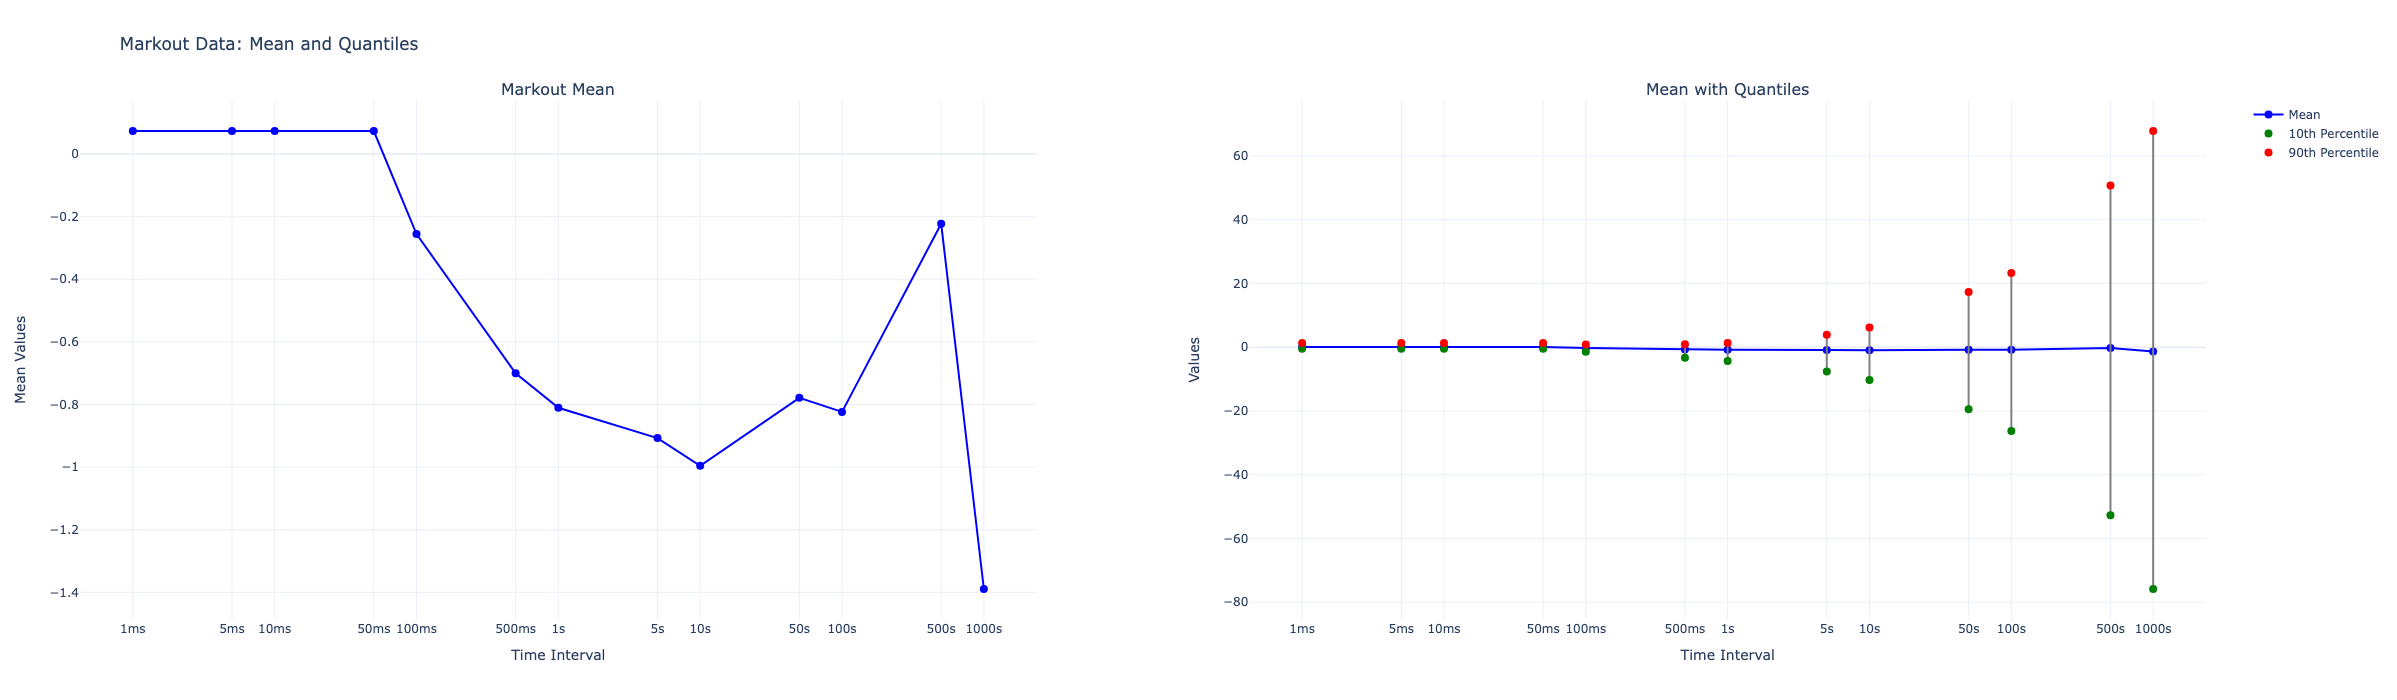

In [587]:
# Meta Setting
test = BacktestEngine(sep10_trades, sep10_ob)  # BacktestEngine(trades_bnc, order_book_bnc_25)
test.update_strat_config(update_tol = 1.0, order_qty = 1.0, min_margin = 1.0)
test.update_env_variables(default_latency = 5, latency_type = 'fixed', rebates = 0.5)
test.update_sample_filter(latency_range = (0, 10), tail_sample_truncate = 1000)

# Run the Backtest
test.run_backtest()

# Show the markout plot
test.plot()

In [581]:
test.stats

bid_filled_volume,ask_filled_volume,bid_fill_rate,ask_fill_rate
f64,f64,f64,f64
3351.06,3308.328,0.177361,0.175099


In [ ]:
t = test.orders_markout_added

# self.mid_val_ts = None
# self.orders = None
# self.orders_latency_applied = None
# self.orders_queue_added = None
# self.orders_trades_matched = None
# self.orders_markout_added = None
# self.markout_fill_rate_applied = None
# self.stats = None

### Unit Test

In [694]:
test_df = pl.DataFrame({
    "local_timestamp": [111300, 111301, 111302, 111303, 111304, 111305],
    "ask[0].price": [1, 2, 3, 4, 5, 6],
    "ask[0].amount": [21, 22, 23, 24, 25, 26],
    "ask[1].price": [2, 3, 4, 5, 6, 7],
    "ask[1].amount": [22, 23, 24, 25, 26, 27],
    "ask[2].price": [3, 4, 5, 6, 7, 8],
    "ask[2].amount": [23, 24, 25, 26, 27, 28],
    "ask[3].price": [4, 5, 6, 7, 8, 9],
    "ask[3].amount": [24, 25, 26, 27, 28, 29],
    "ask_quote_px": [3, 3, 3, 4, 4, 9],
    "test_1": [1, 2, 3, 1, 2, 6],
    "test_2": [2, 2, 2, 2, 2, 2],
    "order_arrived_time": [1111, 1111, 1111, 2222, 2222, 2222]
    # Continue for price_4 to price_10 and amount_4 to amount_10
})